# 2.1 Analyses of combined states - flow fields

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, best__kappa, best_lag_kappa, state_identifiability
from plotting_functions import plot_x_y_dynamics, plot_avg_state, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, plot_states_aligned, traces_over_few_sates

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Parameters

In [2]:
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

num_train_batches = 5
threshold = 0.01
sticky = False

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]


## Get data

In [3]:
# Load preprocessed data
prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
os.chdir(prepro_results_path)
idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + "preprocessed_data_v4_170724", "rb"))
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

In [4]:
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me']]
var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
idx_init_list = [0, 1, 2, 3, 7]
idx_end_list = [1, 2, 3, 7, 9]

## Plot combined states per animal

In [5]:
# Loop through animals
for m, mouse_name in enumerate(np.unique(mouse_names)):
    try:
        var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']

        # Get mouse data
        session_trials = collapsed_trials[mouse_name].copy()
        design_matrix = collapsed_matrices[mouse_name][:,0:3].copy()  # TODO: find a way for this not to be hardcoded
        unnorm_mat = collapsed_unnorm[mouse_name][var_names].copy()
        unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin'].copy()

        # Get states per variable and concatenate
        states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
        os.chdir(states_path)

        c_states = []
        for s, set in enumerate(use_sets):
            
            most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name, "rb"))
            # Save
            if len(c_states) == 0:
                c_states = most_likely_states
            else:
                c_states = np.vstack((c_states, most_likely_states))      
        
        combined_states = remove_states_str(c_states.T, threshold)
            
        # Change states back to integer
        state_labels = np.unique(combined_states)
        int_state = np.arange(0, len(state_labels), 1).astype(float)
        if state_labels[-1] == 'nan':
            int_state[-1] = np.nan
        # Define the mapping as a dictionary
        mapping = {unique: key for unique, key in zip(state_labels, int_state)}

        # Use np.vectorize to apply the mapping
        replace_func = np.vectorize(mapping.get)
        new_states = replace_func(combined_states)

        " Prepare data "
        # Prepare data 
        num_timesteps = np.shape(design_matrix)[0]
        num_states = len(np.unique(new_states))
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(new_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
        # Fix discontinuities
        cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
        
        # Align bins
        init = -1 * multiplier
        end = 1.5 * multiplier
        empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)
        states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)

        """ Plot raw traces over states """
        init = 250 * multiplier # First bin
        inter = 10 * multiplier
        traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
        # traces_over_sates(init, inter, empirical_data, cont_trials)
        
        
        """ Compute dynamics """
        # Initialize dynamics var
        dynamics = defaultdict(list)
        dynamics[mouse_name] = {}
            
        # Get mouse data
        session_trials = collapsed_trials[mouse_name]
        design_matrix = collapsed_matrices[mouse_name]
        unnorm_mat = collapsed_unnorm[mouse_name]

        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = unnorm_mat[var_names]

        for s, set in enumerate(use_sets):
            
            # Get best params
            params_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/grid_search/'
            # results_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Results/'
            os.chdir(params_path)
            
            all_lls, all_baseline_lls, _, all_fit_params = pickle.load(open("best_results_" + set[0] + '_' + mouse_name, "rb"))
            dynamics[mouse_name][set[0]] = {}
            
            if 'Lick count' in set:
                best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
                index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                use_fold = int(best_fold[index_kappa])
                dynamics[mouse_name][set[0]]['rates'] = all_fit_params[best_kappa].emissions.rates[use_fold]
            else:
                best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)
                index_lag = np.where(np.array(Lags)==best_lag)[0][0]
                index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                use_fold = int(best_fold[index_lag, index_kappa])
                dynamics[mouse_name][set[0]]['weights'] = all_fit_params[best_lag][best_kappa].emissions.weights[use_fold]
                dynamics[mouse_name][set[0]]['biases'] = all_fit_params[best_lag][best_kappa].emissions.biases[use_fold]
        
        """ Plot state empirical mean """
        inverted_mapping = {v: k for k, v in mapping.items()}
        unique_states = np.array(list(inverted_mapping.keys()))
        unique_states = unique_states[~np.isnan(unique_states)] 
        plot_avg_state(unique_states, empirical_data, inverted_mapping)

        """ Plot dynamics """
        x_var = 'avg_wheel_vel'
        y_var = 'whisker_me'
        mouse_dynamics = dynamics[mouse_name]
        grid_density = 20
        trajectory_num = 10
        plot_traj = True
        plot_x_y_dynamics(x_var, y_var, dynamics, mouse_name, new_states, design_matrix_heading, inverted_mapping, 
                            grid_density, trajectory_num, plot_traj)  

    except:
        print(mouse_name)

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

CSHL045
CSHL047
CSHL049
CSHL051
CSHL052
CSHL054
CSHL058


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

CSHL059
CSHL060
DY_008
DY_009
DY_013
DY_014
DY_016
DY_018
KS014
KS022
KS023
KS044
KS051
KS084
KS086
KS091
KS096
NR_0020
NYU-45
PL015
PL016
PL017
SWC_038
SWC_043
SWC_052
SWC_053
SWC_054
SWC_058
SWC_061
SWC_065
SWC_066
UCLA012
UCLA033
UCLA034
UCLA035
UCLA037
ZFM-01592
ZFM-01935
ZFM-01936
ZFM-02369
ZFM-02370
ZFM-02372
ZFM-02373
ZM_1898
ZM_2240
ZM_2241
ZM_2245
ZM_3003
ibl_witten_25
ibl_witten_26
ibl_witten_29


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

## Plot combined states per session

In [5]:
exclude_sessions = ['f1db6257-85ef-4385-b415-2d078ec75df2',
'259927fd-7563-4b03-bc5d-17b4d0fa7a55',
'e49d8ee7-24b9-416a-9d04-9be33b655f40',
'6f6d2c8e-28be-49f4-ae4d-06be2d3148c1',
'193fe7a8-4eb5-4f3e-815a-0c45864ddd77',
'f8d5c8b0-b931-4151-b86c-c471e2e80e5d',
'ebc9392c-1ecb-4b4b-a545-4e3d70d23611',
'537677fe-1e24-4755-948c-fa4a4e8ecce5',
'a4747ac8-6a75-444f-b99b-696fff0243fd',
'7be8fec4-406b-4e74-8548-d2885dcc3d5e',
'a71175be-d1fd-47a3-aa93-b830ea3634a1',
'53738f95-bd08-4d9d-9133-483fdb19e8da',
'd901aff5-2250-467a-b4a1-0cb9729df9e2',
'7939711b-8b4d-4251-b698-b97c1eaa846e',
'510b1a50-825d-44ce-86f6-9678f5396e02',
'aad23144-0e52-4eac-80c5-c4ee2decb198',
'd839491f-55d8-4cbe-a298-7839208ba12b',
'72cb5550-43b4-4ef0-add5-e4adfdfb5e02']

session is 934dd7a4-fbdc-459c-8830-04fe9033bc28


/tmp/ipykernel_18120/4005919394.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

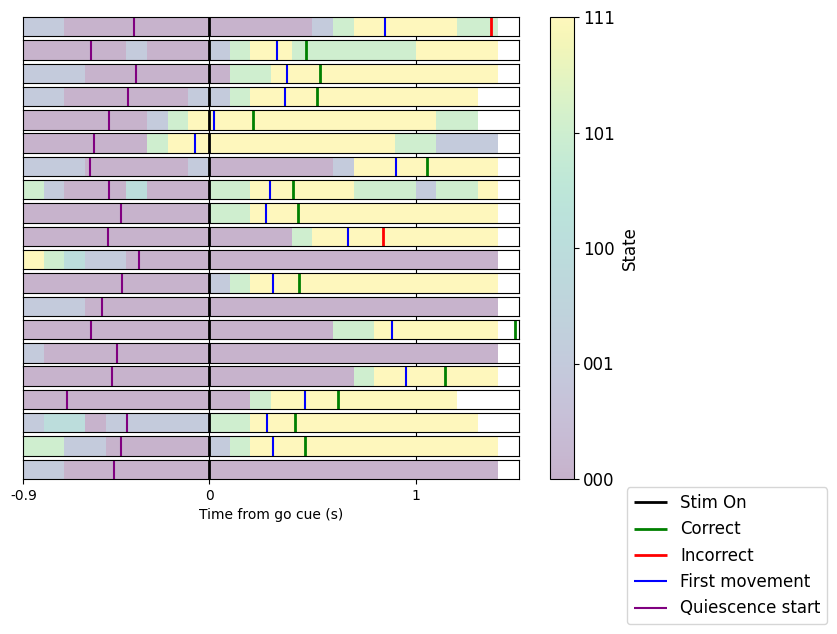

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]


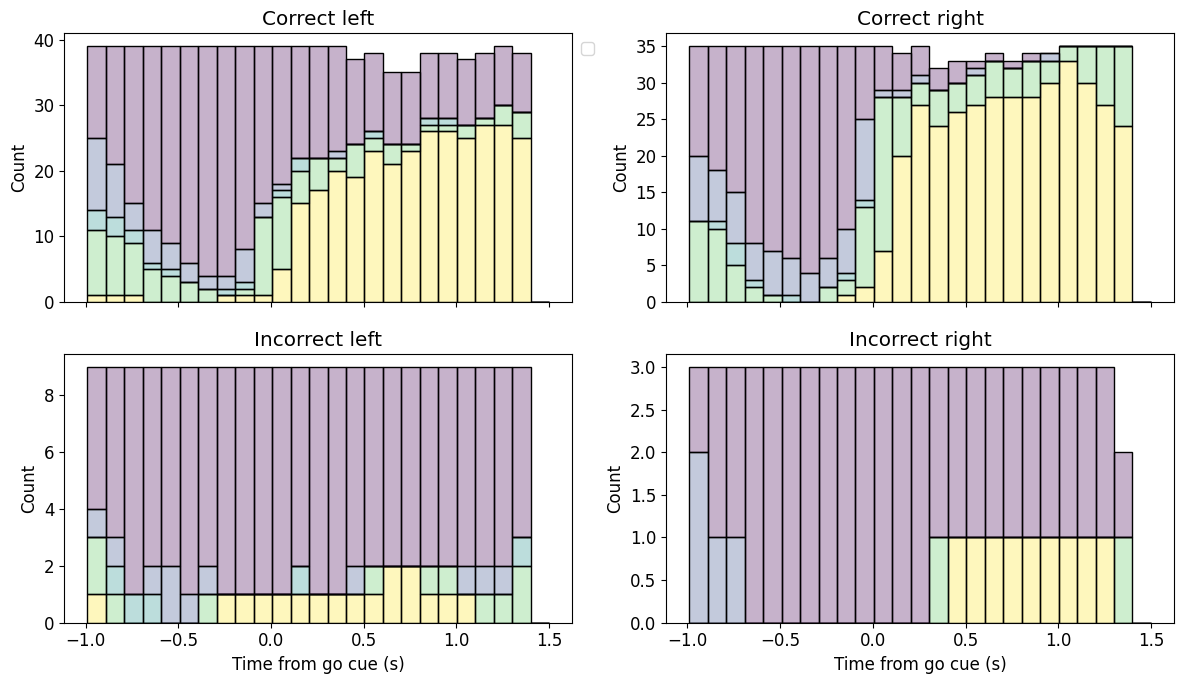

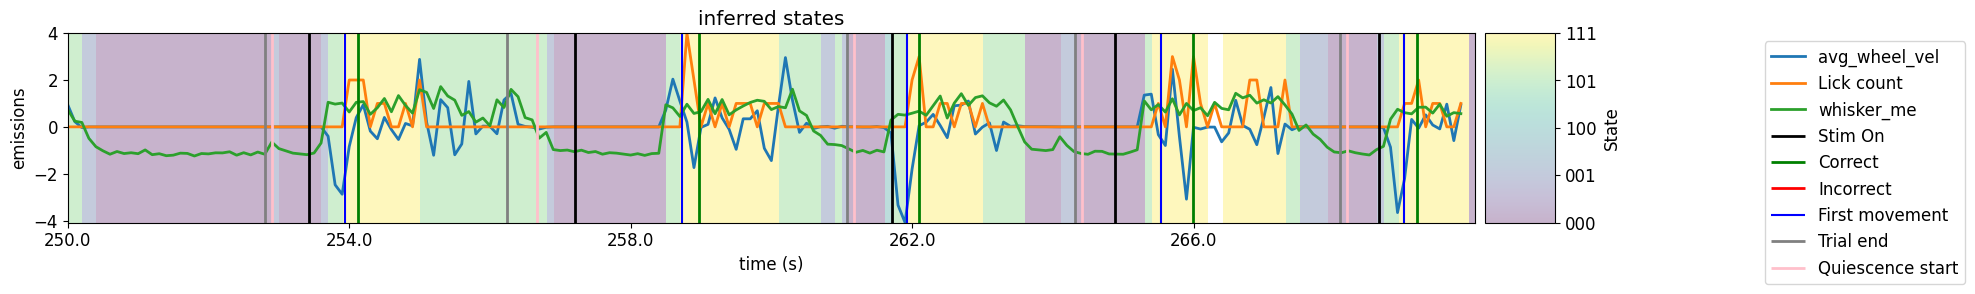

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:761: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='variable', x='value', data=use_data, ax=ax[0,s], palette='plasma')
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:761: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='variable', x='value', data=use_data, ax=ax[0,s], palette='plasma')
/home/ines/repositories/representation_learning_variability/M

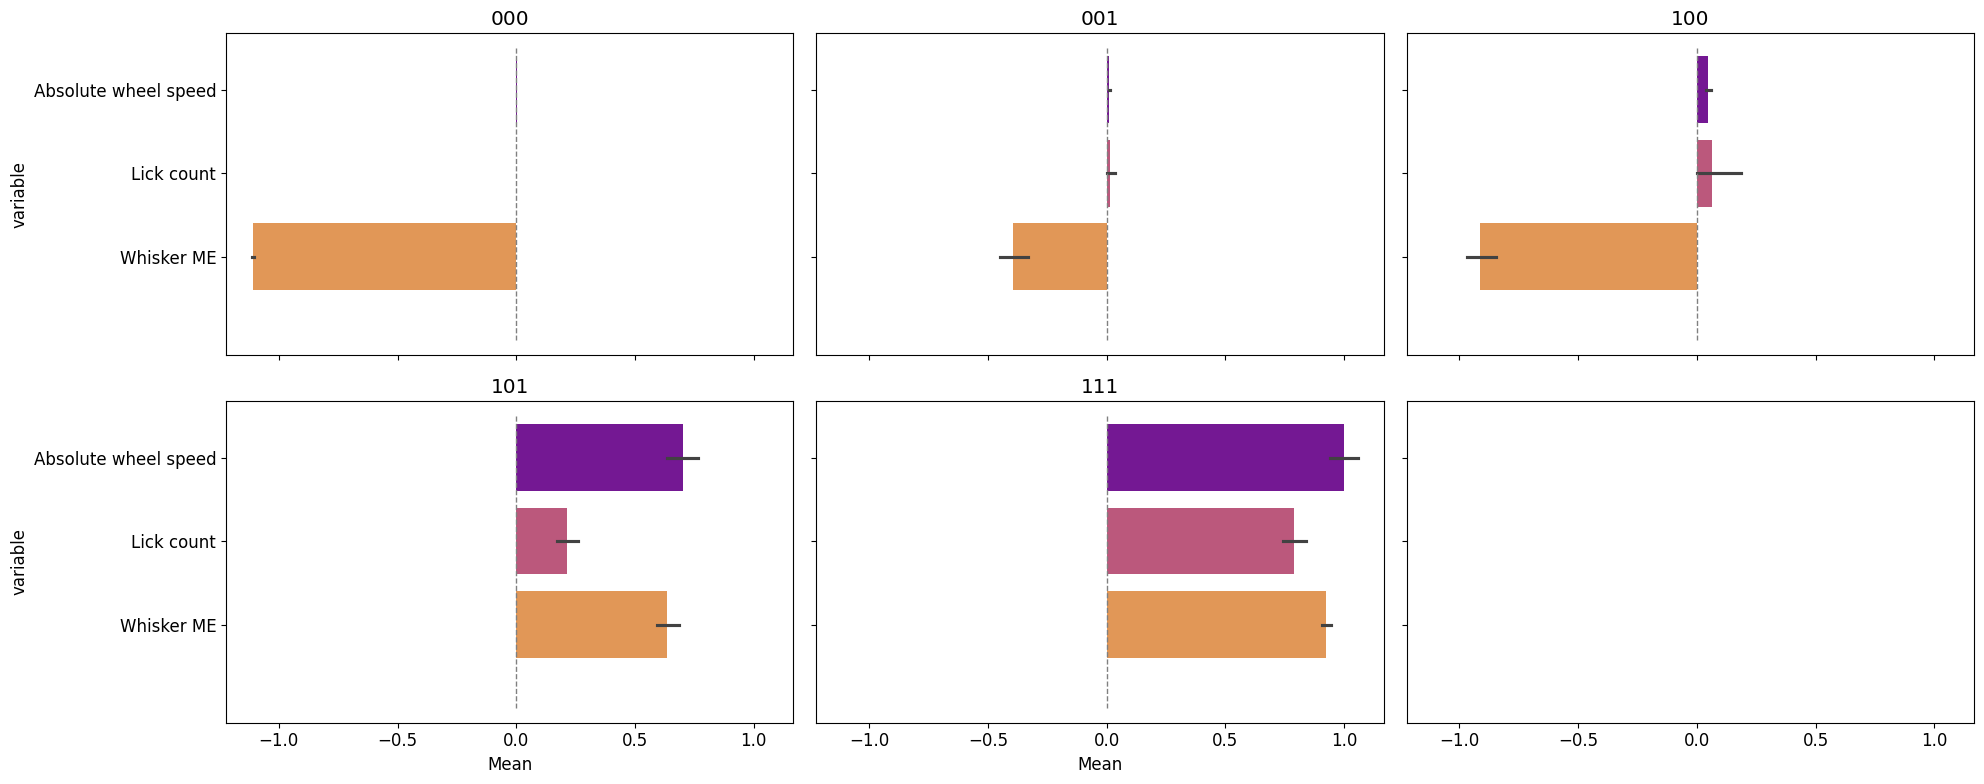

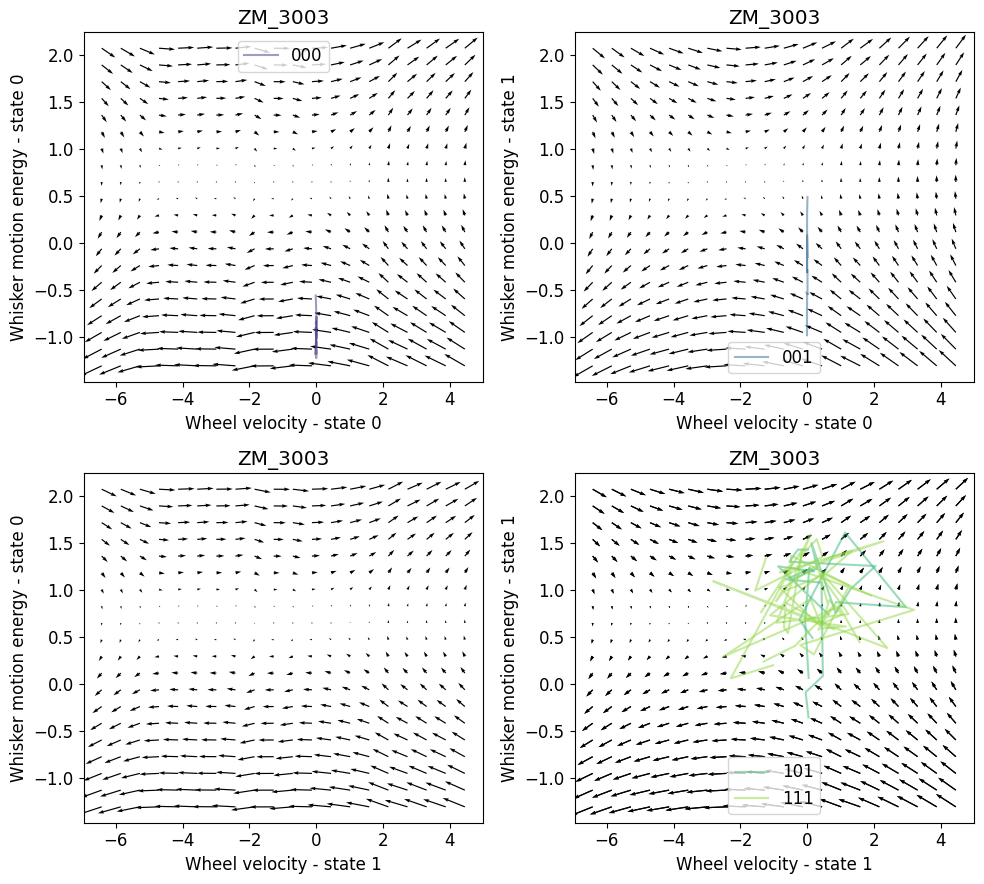

In [6]:
for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
        # try:
        mouse_name = mat[37:]
        session = mat[0:36]
        mouse_name = 'ZM_3003'
        session = '934dd7a4-fbdc-459c-8830-04fe9033bc28'
        if session not in exclude_sessions:
            print('session is ' +session)
            var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']

            # Get mouse data          
            session_trials = session_all[mouse_name][session].reset_index()
            design_matrix = matrix_all[mouse_name][session][:,0:3]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            # Get states per variable and concatenate
            states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
            os.chdir(states_path)

            c_states = []
            for s, set in enumerate(use_sets):
                
                most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name + session, "rb"))
                # Save
                if len(c_states) == 0:
                    c_states = most_likely_states
                else:
                    c_states = np.vstack((c_states, most_likely_states))      
            
            combined_states = remove_states_str(c_states.T, threshold)
            
            " Prepare data "
            num_timesteps = np.shape(design_matrix)[0]
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(combined_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
            
            # Transform states into identifiable states
            identifiable_states = state_identifiability(combined_states, design_matrix_heading)
            
            # Change states back to integer
            state_labels = np.unique(identifiable_states)
            int_state = np.arange(0, len(state_labels), 1).astype(float)
            if state_labels[-1] == 'nan':
                int_state[-1] = np.nan
            # Define the mapping as a dictionary
            mapping = {unique: key for unique, key in zip(state_labels, int_state)}
            inverted_mapping = {v: k for k, v in mapping.items()}

            # Use np.vectorize to apply the mapping
            replace_func = np.vectorize(mapping.get)
            new_states = replace_func(identifiable_states)
            num_states = len(np.unique(new_states))

            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)
            empirical_data['identifiable_states'] = identifiable_states
            states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            
            """ Stack trial states """
            trial_init = 10  # First trial to plot
            trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
            plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, inverted_mapping)

            " Plot states stacked and aligned per trial type "
            plot_states_aligned(init, end, empirical_data, event_type_name, bin_size, inverted_mapping)
            
            # """ Plot states per trial epoch """
            # colors = sns.color_palette("viridis", num_states)
            # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            # sns.histplot(x='label', hue='most_likely_states', data=states_trial, stat = 'percent',
            #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
            # # plt.figure(figsize=[7, 5])
            # plt.xticks(rotation=45)
            # plt.tight_layout()
            # plt.title(mouse_name)
            # plt.show()
        
            """ Plot raw traces over states """
            init = int(np.min(empirical_data['Bin'])/10+10) * multiplier # First bin
            init = 250*multiplier
            inter = 10 * multiplier
            inter = 20 * multiplier
            traces_over_few_sates(init, inter, empirical_data, session_trials, var_names, multiplier, inverted_mapping)
            
            """ Compute dynamics """
            # Initialize dynamics var
            dynamics = defaultdict(list)
            dynamics[mouse_name] = {}
            dynamics[mouse_name][session] = {}
                
            for s, set in enumerate(use_sets):
                
                # Get best params
                params_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/grid_search/individual_sessions/'
                # results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Results/'
                os.chdir(params_path)
                dynamics[mouse_name][session][set[0]] = {}
                if 'Lick count' in set:
                    all_lls, all_baseline_lls, _, all_fit_params, _, kappas = pickle.load(open("best_results_" + set[0] + '_' + mouse_name + session, "rb"))
                    best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
                    index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                    use_fold = int(best_fold[index_kappa])
                    dynamics[mouse_name][session][set[0]]['rates'] = all_fit_params[best_kappa].emissions.rates[use_fold]
                else:
                    all_lls, all_baseline_lls, _, all_fit_params, _, kappas, Lags = pickle.load(open("best_results_" + set[0] + '_' + mouse_name + session, "rb"))
                    best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)
                    index_lag = np.where(np.array(Lags)==best_lag)[0][0]
                    index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                    use_fold = int(best_fold[index_lag, index_kappa])
                    dynamics[mouse_name][session][set[0]]['weights'] = all_fit_params[best_lag][best_kappa].emissions.weights[use_fold]
                    dynamics[mouse_name][session][set[0]]['biases'] = all_fit_params[best_lag][best_kappa].emissions.biases[use_fold]
            
            """ Plot state empirical mean """
            unique_states = np.array(list(inverted_mapping.keys()))
            unique_states = unique_states[~np.isnan(unique_states)] 
            plot_avg_state(unique_states, empirical_data, inverted_mapping)

            """ Plot dynamics """
            x_var = 'avg_wheel_vel'
            y_var = 'whisker_me'
            mouse_dynamics = dynamics[mouse_name][session]
            grid_density = 20
            trajectory_num = 5
            plot_traj = True
            plot_x_y_dynamics(x_var, y_var, mouse_dynamics, mouse_name, new_states, design_matrix_heading, inverted_mapping, 
                                grid_density, trajectory_num, plot_traj)  
        else:
            print(session)


In [57]:
def plot_states_aligned(init, end, reduced_design_matrix, event_type_name, bin_size, inverted_mapping):

    for e, this_event in enumerate(event_type_name):
            
        # PLOT
        fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=[12, 7])
        plt.rc('font', size=12)
        use_data = reduced_design_matrix.dropna()
        use_data['new_bin'] = use_data['new_bin'] * bin_size
        #use_data = use_data[:test_length*2]
        
        # Correct left

        a = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                                & (use_data['choice']=='left')], stat='count', alpha=0.3, 
                        multiple="stack", binwidth=bin_size, binrange=(bin_size*init+0.01, bin_size*end), legend=True, ax = ax[0, 0], palette='viridis')
        # Correct right
        b = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                                & (use_data['choice']=='right')], stat='count', alpha=0.3, 
                        multiple="stack", binwidth=bin_size, binrange=(bin_size*init+0.01, bin_size*end), legend=False, ax = ax[0, 1], palette='viridis')
        # Incorrect left
        c = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                                & (use_data['choice']=='left')], stat='count', alpha=0.3,
                        multiple="stack", binwidth=bin_size, binrange=(bin_size*init+0.01, bin_size*end), legend=False, ax = ax[1, 0], palette='viridis')
        # Incorrect right
        d = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                                & (use_data['choice']=='right')], alpha=0.3, 
                        stat='count', multiple="stack", binwidth=bin_size, binrange=(bin_size*init+0.01, bin_size*end), legend=False, ax = ax[1, 1], palette='viridis')
        
        
        ordered_labels = [inverted_mapping[hue] for hue in sorted(use_data.loc[(use_data['correct']==1) 
                                                                                & (use_data['choice']=='left'), 'most_likely_states'].unique())]
        # Get current handles and labels
        handles, _ = ax[0, 0].get_legend_handles_labels()
        print(handles)

        # Set custom labels
        ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
        ax[0, 0].set_title(str('Correct left'))
        ax[0, 0].set_xlabel(str('Time from go cue (s)'))

        ax[0, 1].set_title(str('Correct right'))
        ax[0, 1].set_xlabel(str('Time from go cue (s)'))
        
        ax[1, 0].set_title(str('Incorrect left'))
        ax[1, 0].set_xlabel(str('Time from go cue (s)'))
        
        ax[1, 1].set_title(str('Incorrect right'))
        ax[1, 1].set_xlabel(str('Time from go cue (s)'))
        
        plt.tight_layout()
        plt.show()

<AxesSubplot:xlabel='most_likely_states', ylabel='value'>

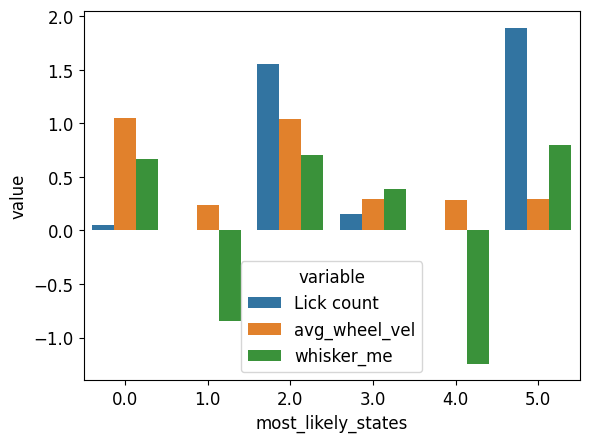

In [28]:
sns.barplot(x='most_likely_states', y='value', hue='variable', data=grouped)

In [16]:
for m, mat in enumerate(idxs): #
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        session = mat[0:36]
        try:
            var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']

            # Get mouse data
            session_trials = collapsed_trials[mouse_name].copy()
            design_matrix = collapsed_matrices[mouse_name][:,0:3].copy()  # TODO: find a way for this not to be hardcoded
            unnorm_mat = collapsed_unnorm[mouse_name][var_names].copy()
            unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin'].copy()

            # Get states per variable and concatenate
            states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
            os.chdir(states_path)

            c_states = []
            for s, set in enumerate(use_sets):
                
                most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name + session, "rb"))
                # Save
                if len(c_states) == 0:
                    c_states = most_likely_states
                else:
                    c_states = np.vstack((c_states, most_likely_states))      
            
            combined_states = remove_states_str(c_states.T, threshold)
                
            # Change states back to integer
            state_labels = np.unique(combined_states)
            int_state = np.arange(0, len(state_labels), 1).astype(float)
            if state_labels[-1] == 'nan':
                int_state[-1] = np.nan
            # Define the mapping as a dictionary
            mapping = {unique: key for unique, key in zip(state_labels, int_state)}

            # Use np.vectorize to apply the mapping
            replace_func = np.vectorize(mapping.get)
            new_states = replace_func(combined_states)

            " Prepare data "
            # Prepare data 
            num_timesteps = np.shape(design_matrix)[0]
            num_states = len(np.unique(new_states))
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(new_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
            # Fix discontinuities
            cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
            
            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)
            states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)

            """ Plot raw traces over states """
            init = 250 * multiplier # First bin
            inter = 10 * multiplier
            traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
            # traces_over_sates(init, inter, empirical_data, cont_trials)
            
            
            """ Compute dynamics """
            # Initialize dynamics var
            dynamics = defaultdict(list)
            dynamics[mouse_name] = {}
                
            # Get mouse data
            session_trials = collapsed_trials[mouse_name]
            design_matrix = collapsed_matrices[mouse_name]
            unnorm_mat = collapsed_unnorm[mouse_name]

            if len(np.shape(design_matrix)) > 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                unnorm_mat = matrix_all_unnorm[mouse_name][0]
                
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = unnorm_mat[var_names]

            for s, set in enumerate(use_sets):
                
                # Get best params
                params_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/grid_search/individual_sessions/'
                # results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Results/'
                os.chdir(params_path)
                
                all_lls, all_baseline_lls, _, all_fit_params = pickle.load(open("best_results_" + set[0] + '_' + mouse_name, "rb"))
                dynamics[mouse_name][set[0]] = {}
                
                if 'Lick count' in set:
                    best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
                    index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                    use_fold = int(best_fold[index_kappa])
                    dynamics[mouse_name][set[0]]['rates'] = all_fit_params[best_kappa].emissions.rates[use_fold]
                else:
                    best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)
                    index_lag = np.where(np.array(Lags)==best_lag)[0][0]
                    index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                    use_fold = int(best_fold[index_lag, index_kappa])
                    dynamics[mouse_name][set[0]]['weights'] = all_fit_params[best_lag][best_kappa].emissions.weights[use_fold]
                    dynamics[mouse_name][set[0]]['biases'] = all_fit_params[best_lag][best_kappa].emissions.biases[use_fold]
            
            """ Plot state empirical mean """
            inverted_mapping = {v: k for k, v in mapping.items()}
            unique_states = np.array(list(inverted_mapping.keys()))
            unique_states = unique_states[~np.isnan(unique_states)] 
            plot_avg_state(unique_states, empirical_data, inverted_mapping)

            """ Plot dynamics """
            x_var = 'avg_wheel_vel'
            y_var = 'whisker_me'
            mouse_dynamics = dynamics[mouse_name]
            grid_density = 20
            trajectory_num = 10
            plot_traj = True
            plot_x_y_dynamics(x_var, y_var, dynamics, mouse_name, new_states, design_matrix_heading, inverted_mapping, 
                                grid_density, trajectory_num, plot_traj)  

        except:
            print(mouse_name)

ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003
ZM_3003


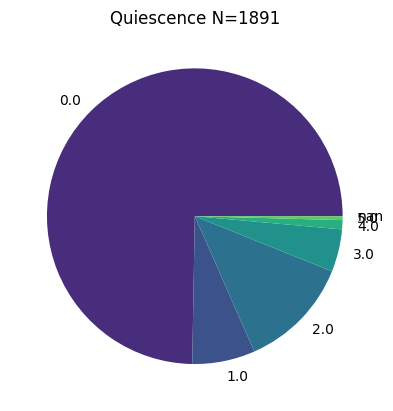

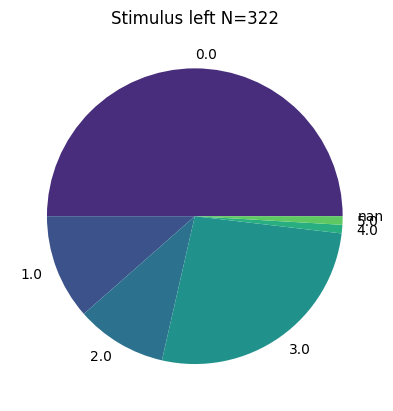

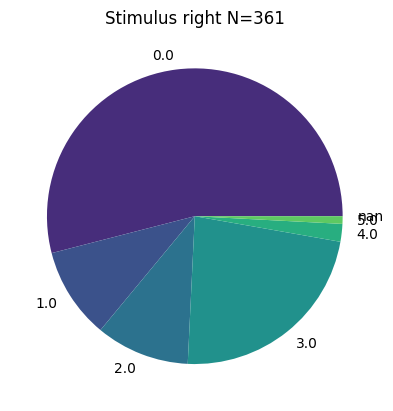

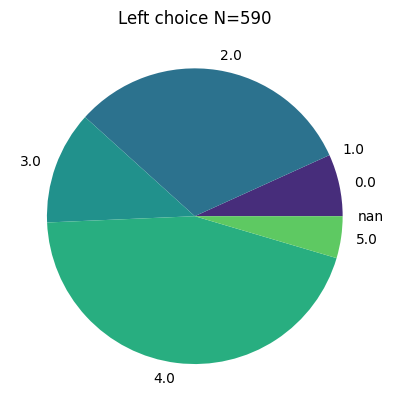

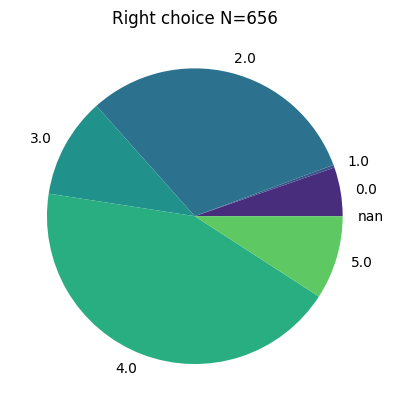

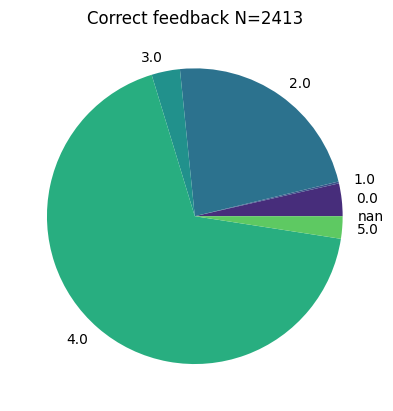

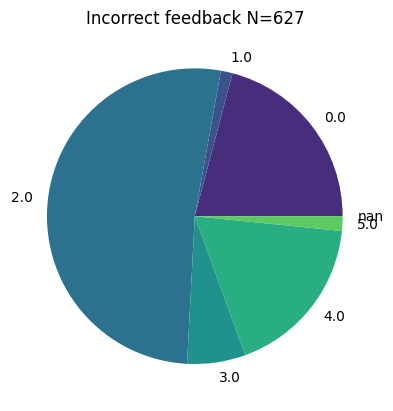

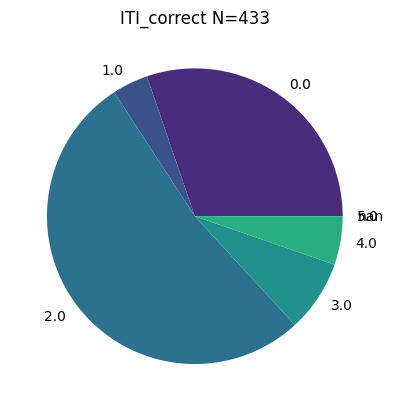

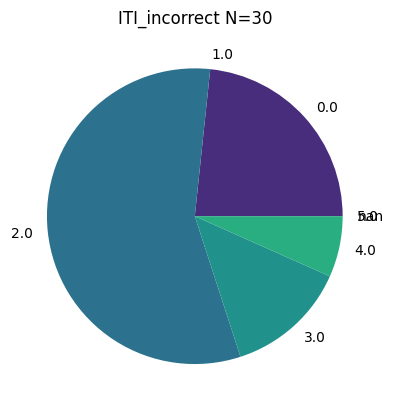

In [8]:
palette_color = sns.color_palette('viridis', n_colors=num_states)
epochs = states_trial['label'].unique()

st = np.unique(new_states)

for epoch in epochs:
    all_counts = np.zeros(len(st))
    unique, counts = np.unique(states_trial.loc[states_trial['label']==epoch, 0], return_counts=True)
    all_counts[unique.astype(int)] = counts
    plt.pie(all_counts, labels=st,  colors=palette_color)  # , labels=keys
    plt.title(str(epoch + ' N=' + str(int(sum(all_counts))) ))
    plt.show()